/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:110: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


gm imax, jmax 128 128
x-loc    y-loc   DAU       DM       CHANNEL  PIXEL   
(4, 4)
(64, 64)
(128, 128)


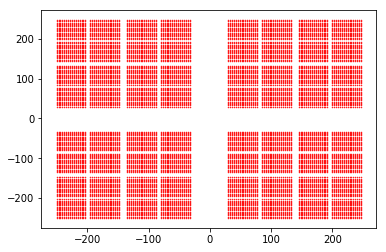

In [49]:
%matplotlib inline
#!/usr/bin/env python3
import pprint

import numpy as np
import pandas as pd
from bitstring import Bits
from matplotlib.table import Table


class MXGSAddress(object):
    def __init__(self):
        # CZT DAU Design report
        self.led_width = 380
        self.dau_lattice_separation = 190
        self.dm_lattice_separation = 46
        self.pixel_lattice_separation = 2.5
        self.sz = 4
        self.n = 16
        self.mxgs_locations = {}
        self.x_loc = 0
        self.y_loc = 0
        self.channel = 0
        self.pixel = 0
        self.dau = 0
        self.dm = 0
        self.asic = 0
        self.address_df = 0
        self.address_dict = 0
        self.x_offset = 0
        self.y_offset = 0
        self.build_address()

    def setup_dau(self):
        #  setting up dau and asic numbers
        dau = np.array([[1, 3], [2, 4]])
        self.dau = dau.repeat(64, axis=0).repeat(64, axis=1)

    def setup_dm(self):
        dm = np.linspace(1, 16, 16, dtype=np.int16)
        dm = np.reshape(dm, [4, 4])
        dm = dm.repeat(16, axis=0).repeat(16, axis=1)
        self.dm = self.clone_dau_to_czt(dm)

    def setup_asic(self):
        asic = np.array([[1, 2], [1, 2]])
        asic = asic.repeat(8, axis=0).repeat(8, axis=1)
        asic = self.setup_czt(asic)
        self.asic = asic

    def setup_pixel(self, index):
        pixel_number = np.linspace(1, self.n * self.n, self.n * self.n, dtype=np.int16)
        values = np.reshape(pixel_number, (self.n, self.n))
        values = np.transpose(values)
        values = pd.DataFrame(values, index=index)
        self.pixel = self.setup_czt(values)

    def setup_channel(self):
        n = self.n
        asic_c1 = np.array([89, 87, 84, 78, 94, 85, 74, 68,
                            61, 55, 49, 39, 42, 41, 38, 34,
                            88, 86, 82, 80, 92, 83, 72, 66,
                            63, 57, 51, 35, 47, 45, 40, 36,
                            91, 97, 103, 76, 96, 90, 81, 70,
                            64, 59, 53, 44, 37, 43, 26, 30,
                            93, 99, 105, 98, 104, 77, 71, 65,
                            62, 56, 50, 21, 27, 31, 24, 32,
                            95, 101, 107, 100, 106, 75, 69, 67,
                            60, 54, 48, 33, 25, 29, 22, 28,
                            109, 121, 115, 127, 102, 79, 73, 108,
                            58, 52, 46, 5, 10, 6, 12, 20,
                            113, 125, 119, 128, 122, 118, 114, 110,
                            19, 13, 11, 7, 1, 4, 14, 18,
                            117, 111, 123, 126, 124, 120, 116, 112,
                            23, 17, 15, 9, 3, 8, 2, 16])

        asic_c2 = np.array([20, 14, 4, 10, 7, 11, 15, 19,
                            110, 114, 118, 124, 127, 115, 121, 109,
                            18, 12, 6, 1, 5, 9, 13, 17,
                            108, 112, 116, 122, 128, 119, 125, 113,
                            16, 2, 8, 3, 33, 50, 56, 23,
                            71, 77, 104, 120, 126, 123, 111, 117,
                            28, 22, 27, 21, 48, 54, 60, 62,
                            69, 75, 106, 102, 98, 105, 101, 95,
                            32, 26, 29, 25, 46, 52, 58, 64,
                            67, 73, 79, 100, 107, 103, 93, 91,
                            30, 24, 31, 43, 37, 44, 53, 59,
                            65, 70, 81, 90, 96, 76, 99, 97,
                            34, 40, 45, 47, 35, 51, 57, 63,
                            66, 72, 83, 92, 80, 82, 86, 88,
                            36, 38, 41, 42, 39, 49, 55, 61,
                            68, 74, 85, 94, 78, 84, 87, 89])

        channel_number = np.concatenate((asic_c1, asic_c2), axis=0)
        # print (asic_c1.size)
        channel = np.reshape(channel_number, (n, n))
        channel = np.transpose(channel)
        channel = np.flipud(channel)
        self.channel = self.setup_czt(channel)

    def build_address(self):
        n = self.n
        # setup pixel data
        index = np.linspace(1, self.n, self.n)
        self.setup_pixel(index)

        self.setup_channel()

        index = np.linspace(1, n, n)
        channel_index = np.linspace(1, n * n / 2, n * n / 2)
        channel_datadf = pd.DataFrame(self.channel, index=channel_index)

        # self.checkerboard_table(channel_datadf)
        # plt.savefig('channel.png')
        # self.checkerboard_table(self.pixel)
        # plt.savefig('pixel.png')


        # plt.imshow(np.flipud(dau))
        # plt.imshow(self.asic)

        # setting up dm numbering
        self.setup_dm()
        self.setup_dau()
        self.setup_asic()

        imax = self.channel.shape[0]
        jmax = self.channel.shape[1]
        print('gm imax, jmax', imax, jmax)

        xloc = np.zeros_like(self.dau, dtype=np.float)
        yloc = np.zeros_like(self.dau, dtype=np.float)
        dpuaddress = np.zeros_like(self.dau)
        dpuaddress[:, :] = 0

        print('{:7s}  {:7s} {:8s}  {:8s} {:8s} {:8s}'.format('x-loc', 'y-loc', 'DAU', 'DM', 'CHANNEL', 'PIXEL',
                                                             align='right'))

        czt_size = 400

        for j in range(0, jmax):
            for i in range(0, imax):
                xloc[i, j] = (i - imax / 2) / imax * czt_size
                yloc[i, j] = (j - jmax / 2) / jmax * czt_size

                # print((j - jmax) * 40.)

                dau_address = Bits(uint=self.dau[i, j] - 1, length=2)
                asic_number = Bits(uint=self.asic[i, j] - 1, length=1)
                dm_address = Bits(uint=self.dm[i, j] - 1, length=4)
                asic_channel = Bits(uint=self.channel[i, j] - 1, length=7)

                dpu_address_bits = dau_address + asic_number + dm_address + asic_channel
                dpuaddress[i, j] = dpu_address_bits.uint

        # self.pixel = pd.DataFrame(values, index=index)
        # index2 = np.linspace(1, imax, imax)
        # xloc_pd = pd.DataFrame(xloc, index=index2)
        # self.checkerboard_table(xloc_pd)
        # plt.savefig("xloc.png")
        self.setup_separation_offsets()
        self.x_loc = xloc + self.x_offset
        self.y_loc = yloc + self.y_offset
        self.pixel = self.pixel
        self.asic = self.asic
        address_locations = {
            'dpuaddress': np.ravel(dpuaddress),
            'xloc': np.ravel(xloc),
            'yloc': np.ravel(yloc),
            'dau': np.ravel(self.dau),
            'dm': np.ravel(self.dm),
            'asic': np.ravel(self.asic),
            'channel': np.ravel(self.channel),
            'pixel': np.ravel(self.pixel)}

        address_df = pd.DataFrame(address_locations,
                                  columns=['dpuaddress', 'xloc', 'yloc', 'dau', 'dm', 'asic', 'channel', 'pixel'])

        self.address_df = address_df.set_index('dpuaddress')

        my_dict = self.address_df.T.to_dict('list')
        self.address_dict = my_dict



    # This function takes a DAU layout, clones it, rotates x 180 and returns a 2d layout for the entire MXGS CZT
    def clone_dau_to_czt(self, pdau3):
        pdau4 = pdau3

        pdau1 = np.rot90(pdau3, 2)
        pdau2 = pdau1
        pdau12 = np.concatenate((pdau1, pdau2), axis=0)
        pdau34 = np.concatenate((pdau3, pdau4), axis=0)
        pczt = np.concatenate((pdau12, pdau34), axis=1)
        return pczt

    #  function takes a 16x16  DM array and clones it 16 times to make a DAU, then rotates to make a 128x128 CZT array
    def setup_czt(self, arr):
        pchain1 = np.concatenate((arr, arr, arr, arr), axis=1)
        # should use numpy.tile
        pdau3 = np.concatenate((pchain1, pchain1, pchain1, pchain1), axis=0)
        return self.clone_dau_to_czt(pdau3)

    def checkerboard_table(self, data, fmt='{:.0f}', bkg_colors=['white', 'white']):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])

        n_rows, n_cols = data.shape
        width, height = 1.0 / n_cols, 1.0 / n_rows

        # Add cells
        for (i, j), val in np.ndenumerate(data):
            # Index either the first or second item of bkg_colors based on
            # a checker board pattern
            idx = [j % 2, (j + 1) % 2][i % 2]
            color = bkg_colors[idx]

            tb.add_cell(i, j, width, height, text=fmt.format(val),
                        loc='center', facecolor=color)

        # Row Labels...
        for i, label in enumerate(data.index):
            tb.add_cell(i, -1, width, height, text=label, loc='right',
                        edgecolor='none', facecolor='none')
        # Column Labels...
        for j, label in enumerate(data.columns):
            tb.add_cell(-1, j, width, height / 2, text=label, loc='center',
                        edgecolor='none', facecolor='none')
        ax.add_table(tb)
        return fig

    def get_location(self, dpu_address):
        print(dpu_address)
        mxgs_location = self.address_dict.get(dpu_address)
        xloc = mxgs_location[0]
        yloc = mxgs_location[1]
        return xloc, yloc

    def get_loc(self, asic_add, channel_add):
        asic_number = Bits(uint=asic_add, length=7)
        asic_channel = Bits(uint=channel_add, length=7)

        dpu_address_bits = asic_number + asic_channel
        dpu_address = dpu_address_bits.uint
        xloc, yloc = self.get_location(dpu_address)
        return xloc, yloc
    
    def print_it(self):
        # result = self.address_df.sort_values(by=['dau', 'dm', 'asic', 'channel'], ascending=True)
        # result = self.address_df.sort_values(by=['dpuaddress'], ascending=True)
        result = self.address_df.sort_index()
        with open('outfile.txt', 'w') as file_out:
            pp = pprint.PrettyPrinter(indent=4, stream=file_out)
            pd.options.display.max_rows = 17000
            pp.pprint(result)

            # with open('gm_detector_locations.txt', 'wt') as out:
            #    pp = pprint.PrettyPrinter(indent=4, stream=out)
            #    pp.pprint(result)

    
    def setup_separation_offsets(self):
        dau_sep = 40
        dm_sep = 5

        x_dau = np.array([[-dau_sep, dau_sep], [-dau_sep, dau_sep]])
        x_dau = x_dau.repeat(64, axis=0).repeat(64, axis=1)
        self.y_offset = x_dau

        y_dau = np.array([[-dau_sep, -dau_sep], [dau_sep, dau_sep]])
        y_dau = y_dau.repeat(64, axis=0).repeat(64, axis=1)
        self.x_offset = y_dau

        x_dm = np.array([-2 * dm_sep, -dm_sep, dm_sep, 2 * dm_sep])
        x_dm = np.tile(x_dm, (4, 1))
        x_dm = x_dm.repeat(16, axis=0).repeat(16, axis=1)
        x_dm = np.tile(x_dm, (2, 2))
        
        self.y_offset += x_dm
        
        
        y_dm = np.array([[-2 * dm_sep, -dm_sep, dm_sep, 2 * dm_sep]])
        y_dm = y_dm.transpose()
        y_dm = np.tile(y_dm, (1, 4))
        
        print (y_dm.shape)
        y_dm = y_dm.repeat(16, axis=0).repeat(16, axis=1)
        print (y_dm.shape)
        y_dm = np.tile(y_dm, (2, 2))
        print (y_dm.shape)

        self.x_offset += y_dm



mxgs_address = MXGSAddress()


x_arr = mxgs_address.x_loc
y_arr = mxgs_address.y_loc

plt.plot(x_arr, y_arr, '.', markersize=1, color='red')

